Milestone 2: Data Acquisition and Verification [due March 27th; 10% of overall project grade]

Students will undertake the acquisition and preprocessing of data, paying careful attention to critical aspects such as addressing missing data, handling data imbalances, addressing data scaling issues, and identifying other potential data-related challenges to gain a comprehensive understanding of the dataset.

In [ ]:
import pandas as pd
import re
from pathlib import Path
import requests
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

In [ ]:

drive.mount('/content/drive', force_remount=True)
file_path = '/content/drive/My Drive/CS109b Final Project/bird_sound_data.csv'
df = pd.read_csv(file_path)

Mounted at /content/drive


In [ ]:
df.head()
print(len(df))
display(df[df['decimalLatitude'].isnull()])


716626


,gbifID,accessRights,bibliographicCitation,language,license,modified,publisher,references,rightsHolder,type,...,publishedByGbifRegion,level0Gid,level0Name,level1Gid,level1Name,level2Gid,level2Name,level3Gid,level3Name,iucnRedListCategory
115,2243759306,NaN,NaN,NaN,CC_BY_NC_4_0,NaN,Xeno-canto Foundation for Nature Sounds,https://data.biodiversitydata.nl/xeno-canto/ob...,José Carlos Sires y Eloisa Matheu,NaN,...,EUROPE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EN
116,2243759164,NaN,NaN,NaN,CC_BY_NC_4_0,NaN,Xeno-canto Foundation for Nature Sounds,https://data.biodiversitydata.nl/xeno-canto/ob...,José Carlos Sires y Eloisa Matheu,NaN,...,EUROPE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EN
176,2609670091,NaN,NaN,NaN,CC_BY_NC_4_0,NaN,Xeno-canto Foundation for Nature Sounds,https://data.biodiversitydata.nl/xeno-canto/ob...,W.J. Rossouw,NaN,...,EUROPE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LC
378,2848581673,NaN,NaN,NaN,CC_BY_NC_4_0,NaN,Xeno-canto Foundation for Nature Sounds,https://data.biodiversitydata.nl/xeno-canto/ob...,Oswaldo Cortes,NaN,...,EUROPE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
411,2243765895,NaN,NaN,NaN,CC_BY_NC_4_0,NaN,Xeno-canto Foundation for Nature Sounds,https://data.biodiversitydata.nl/xeno-canto/ob...,José Carlos Sires,NaN,...,EUROPE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
716440,2432417333,NaN,NaN,NaN,CC_BY_NC_4_0,NaN,Xeno-canto Foundation for Nature Sounds,https://data.biodiversitydata.nl/xeno-canto/ob...,James Lidster,NaN,...,EUROPE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LC
716497,2243757035,NaN,NaN,NaN,CC_BY_NC_4_0,NaN,Xeno-canto Foundation for Nature Sounds,https://data.biodiversitydata.nl/xeno-canto/ob...,José Carlos Sires,NaN,...,EUROPE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LC
716539,2243758200,NaN,NaN,NaN,CC_BY_NC_4_0,NaN,Xeno-canto Foundation for Nature Sounds,https://data.biodiversitydata.nl/xeno-canto/ob...,Oscar Marin,NaN,...,EUROPE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LC
716557,2243759430,NaN,NaN,NaN,CC_BY_NC_4_0,NaN,Xeno-canto Foundation for Nature Sounds,https://data.biodiversitydata.nl/xeno-canto/ob...,José Carlos Sires y Eloisa Matheu,NaN,...,EUROPE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EN


In [ ]:
df_less_preds = df[['catalogNumber', 'basisOfRecord', 'decimalLatitude', 'decimalLongitude', 'verbatimScientificName']]
df_less_preds.head()


,catalogNumber,basisOfRecord,decimalLatitude,decimalLongitude,verbatimScientificName
0,XC359020,HUMAN_OBSERVATION,52.6372,13.4587,Podiceps grisegena grisegena
1,XC359048,HUMAN_OBSERVATION,12.4741,-16.7670,Coracias abyssinicus
2,XC359066,HUMAN_OBSERVATION,49.6340,26.2213,Carduelis carduelis carduelis
3,XC359084,HUMAN_OBSERVATION,47.3388,7.8398,Erithacus rubecula
4,XC359101,HUMAN_OBSERVATION,54.1243,-0.5623,Emberiza citrinella


22037
1
312.6512042818912
[2.0, 2193.8249999999994]


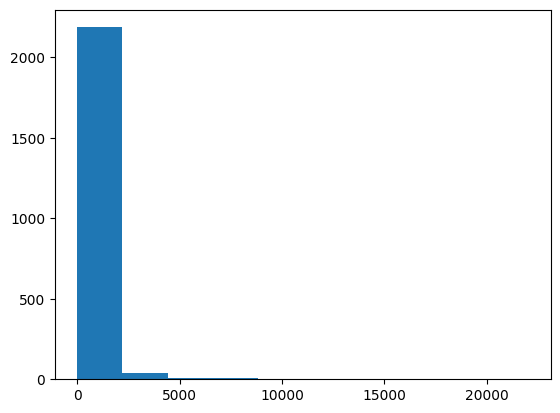

In [ ]:
classFrequencies = df.groupby(['genus']).size().values
plt.hist(classFrequencies)
print(np.max(classFrequencies))
print(np.min(classFrequencies))
print(np.mean(classFrequencies))
print([np.percentile(classFrequencies, 2.5), np.percentile(classFrequencies, 97.5)])


In [ ]:
import os
import shutil
def get_mp3(catalogNumber):
    XCid = re.search(r'\d+$', catalogNumber).group()
    download_url = f'https://xeno-canto.org/{XCid}/download'
    response = requests.get(download_url)
    if response.status_code == 200:
        desired_folder = '/content/drive/My Drive/CS109b Final Project/newmp3s/'
        if not os.path.exists(desired_folder):
          os.mkdir(desired_folder)
        file_path = os.path.join(desired_folder,f'{catalogNumber}.mp3')
        with open(file_path, 'wb') as file:
          file.write(response.content)

In [ ]:
def create_spectrogram(catalogNumber):
    mp3_file_path = f'mp3s/{catalogNumber}.mp3'
    # Load the audio file
    y, sr = librosa.load(mp3_file_path, sr=None)  # Use the original sampling rate

    # Generate the spectrogram
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
    S_dB = librosa.power_to_db(S, ref=np.max)

    # Plot the spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel', fmax=8000)
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'{catalogNumber} Mel-frequency spectrogram')
    plt.tight_layout()
    plt.show()

In [ ]:
df = df[['gbifID', 'references', 'basisOfRecord', 'catalogNumber', 'sex', 'lifeStage', 'behavior', 'associatedTaxa', 'eventTime', 'month', 'continent', 'countryCode', 'verbatimElevation', 'decimalLatitude', 'decimalLongitude', 'mediaType', 'genus', 'species']]
df = df[df['continent'] == 'EUROPE']
X = df[['gbifID', 'references', 'basisOfRecord', 'catalogNumber', 'sex', 'lifeStage', 'behavior', 'associatedTaxa', 'eventTime', 'month', 'countryCode', 'verbatimElevation', 'decimalLatitude', 'decimalLongitude', 'mediaType']]
y = df[['species']]
df = df.dropna(subset=['species'])
df = df[df['associatedTaxa'].isna()]

class_frequencies_scientific_top50 = df.groupby(['species']).size().nlargest(50)
species_to_keep = class_frequencies_scientific_top50.index
df_filtered = df[df['species'].isin(species_to_keep)].drop(['associatedTaxa'], axis=1)

In [ ]:
for catalogNumber in df_filtered['catalogNumber'].values:
  get_mp3(catalogNumber)